In [11]:
import random
import uuid

import pandas as pd

from framelink.core import FramelinkPipeline

In [12]:
# random.seed(123)
pipeline = FramelinkPipeline()


In [13]:
@pipeline.model()
def src_model_1(_: FramelinkPipeline) -> pd.DataFrame:
    """
    Produce a random dataframe of values for examples, ids 0 -> 99
    """
    n = 100
    data = {
        "id_col": list(range(n)),
        "colour_col": [random.choice(["red", "green", "blue"]) for _ in range(n)],
        "uuid_col": [str(uuid.uuid4()) for _ in range(n)],
        "int_col": [random.randint(0, 100) for _ in range(n)],
    }
    return pd.DataFrame(data)


@pipeline.model()
def src_model_2(_: FramelinkPipeline) -> pd.DataFrame:
    """
    Produce a random dataframe of values for examples, ids 100 -> 199
    """
    n = 100
    data = {
        "id_col": list(x + 100 for x in range(n)),
        "colour_col": [random.choice(["yellow", "grey", "blue"]) for _ in range(n)],
        "uuid_col": [str(uuid.uuid4()) for _ in range(n)],
        "int_col": [random.randint(-100, 100) for _ in range(n)],
    }
    return pd.DataFrame(data)

In [14]:
@pipeline.model()
def concat_src_frame(ctx: FramelinkPipeline) -> pd.DataFrame:
    f1 = ctx.ref(src_model_1)
    f2 = ctx.ref(src_model_2)
    return pd.concat((f1, f2), ignore_index=True)

In [15]:
@pipeline.model()
def only_blue_records_by_int_col(ctx: FramelinkPipeline) -> pd.DataFrame:
    res = ctx.ref(concat_src_frame)
    src_blue = res.loc[res["colour_col"] == "blue", :]
    src_blue = src_blue.sort_values(by=["int_col"])
    return src_blue

In [16]:
@pipeline.model()
def blue_head(ctx: FramelinkPipeline) -> pd.DataFrame:
    frame = ctx.ref(only_blue_records_by_int_col)
    return frame.head()


@pipeline.model()
def blue_tail(ctx: FramelinkPipeline) -> pd.DataFrame:
    frame = ctx.ref(only_blue_records_by_int_col)
    return frame.tail()

In [17]:
pipeline.build(only_blue_records_by_int_col)

,id_col,colour_col,uuid_col,int_col
102,102,blue,a1f9530b-5a44-4a08-a53b-7c3348747bff,-99
164,164,blue,83b1fd87-a2ce-41a1-b855-d7d9dffb1d35,-98
103,103,blue,93666c43-5bf8-4f00-a5ea-7c062be0061e,-96
132,132,blue,4f6b9f7d-e157-4bd0-8a8c-8e9747f999b2,-93
104,104,blue,c5d4b3bb-1a00-4ccb-b278-6bf048717569,-84
...,...,...,...,...
71,71,blue,2d09957c-eacf-489c-b8c8-2479db336085,91
41,41,blue,0fb8f9ef-7f0e-4cc6-ae0d-f19b436c7d53,94
117,117,blue,010b3adc-cde1-4fbf-a7dc-3cdce171b27f,96
72,72,blue,d8650819-936c-45ae-916d-d500ff98da05,96


In [18]:
pipeline.build(blue_head)

,id_col,colour_col,uuid_col,int_col
102,102,blue,a1f9530b-5a44-4a08-a53b-7c3348747bff,-99
164,164,blue,83b1fd87-a2ce-41a1-b855-d7d9dffb1d35,-98
103,103,blue,93666c43-5bf8-4f00-a5ea-7c062be0061e,-96
132,132,blue,4f6b9f7d-e157-4bd0-8a8c-8e9747f999b2,-93
104,104,blue,c5d4b3bb-1a00-4ccb-b278-6bf048717569,-84


In [19]:
pipeline.build(blue_tail)

,id_col,colour_col,uuid_col,int_col
71,71,blue,2d09957c-eacf-489c-b8c8-2479db336085,91
41,41,blue,0fb8f9ef-7f0e-4cc6-ae0d-f19b436c7d53,94
117,117,blue,010b3adc-cde1-4fbf-a7dc-3cdce171b27f,96
72,72,blue,d8650819-936c-45ae-916d-d500ff98da05,96
33,33,blue,1f585bc6-3d5e-4c21-8e0e-a192ef43ff33,99


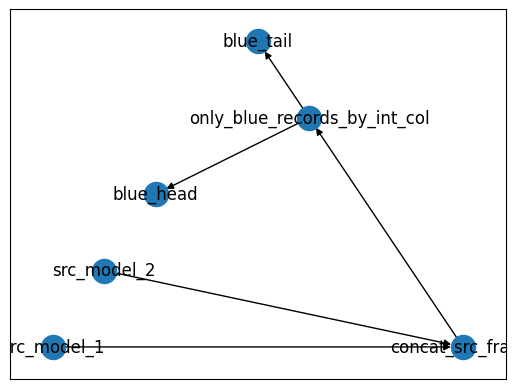

In [20]:
pipeline.graph_plt()

In [16]:
dot_str = pipeline.graph_dot().to_string()
dot_str

'strict digraph  {\nsrc_model_1;\nsrc_model_2;\nconcat_src_frame;\nonly_blue_records_by_int_col;\nblue_head;\nblue_tail;\nsrc_model_1 -> concat_src_frame;\nsrc_model_2 -> concat_src_frame;\nconcat_src_frame -> only_blue_records_by_int_col;\nonly_blue_records_by_int_col -> blue_head;\nonly_blue_records_by_int_col -> blue_tail;\n}\n'